In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# %matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# path  = r'./datasets/FeatureVector'
# print(path)
# import os

In [4]:
# csvs =  os.listdir(path)
# print(csvs)

In [2]:
from datasets.datasets import FaceFeatureData

# Create dataset

# 3 tasks
num_of_people = 3
# 18 examples
num_of_images=18
dataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images)

#82 different people(batch_num)
#18 different images each people(batch_size)
#x_dim = 2048

In [3]:
from model.NeuralProcessModel import NeuralProcess, NeuralProcessEncoder, NeuralProcessDecoder

# Build Neural Process

x_dim = 2048
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

# neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
neuralprocess = {} # a dict
neuralprocess['encoder'] = NeuralProcessEncoder(x_dim, y_dim, r_dim, z_dim, h_dim)#.to(device)
# neuralprocess_decoder = {} # a dict
for i in range(num_of_people):
    neuralprocess[i] = NeuralProcessDecoder(x_dim, y_dim, z_dim, h_dim)#.to(device)

In [4]:
print(neuralprocess)

{'encoder': NeuralProcessEncoder(
  (xy_to_r): Encoder(
    (input_to_hidden): Sequential(
      (0): Linear(in_features=2049, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (r_to_mu_sigma): MuSigmaEncoder(
    (r_to_hidden): Linear(in_features=50, out_features=50, bias=True)
    (hidden_to_mu): Linear(in_features=50, out_features=50, bias=True)
    (hidden_to_sigma): Linear(in_features=50, out_features=50, bias=True)
  )
), 0: NeuralProcessDecoder(
  (xz_to_y): Decoder(
    (xz_to_hidden): Sequential(
      (0): Linear(in_features=2098, out_features=50, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU(inplace=True)
    )
    (hidden_to_mu): Linear(in_f

In [5]:
# print(neuralprocess_encoder)

In [6]:
# print(neuralprocess_decoder)

In [12]:
# i = 0
# for child in neuralprocess.children():
#     i += 1
#     print(i)
#     print(child)
    
#     break

In [5]:
# for param in neuralprocess_encoder.parameters():
#     print(param)

In [11]:
from base import BaseTrainer
print(BaseTrainer)

<class 'base.base_trainer.BaseTrainer'>


Epoch: 0, Avg_loss: 47565.078776041664
Epoch: 1, Avg_loss: 44845.426432291664
Epoch: 2, Avg_loss: 43311.155598958336
Epoch: 3, Avg_loss: 40312.158203125
Epoch: 4, Avg_loss: 37905.376953125
Epoch: 5, Avg_loss: 34328.934244791664
Epoch: 6, Avg_loss: 30850.948567708332
Epoch: 7, Avg_loss: 28452.8115234375
Epoch: 8, Avg_loss: 24693.809244791668
Epoch: 9, Avg_loss: 22288.2265625
Epoch: 10, Avg_loss: 19221.315755208332
Epoch: 11, Avg_loss: 16750.002766927082
Epoch: 12, Avg_loss: 14300.51953125
Epoch: 13, Avg_loss: 11520.989908854166
Epoch: 14, Avg_loss: 9721.62890625
Epoch: 15, Avg_loss: 8430.94677734375
Epoch: 16, Avg_loss: 7271.582194010417
Epoch: 17, Avg_loss: 5840.886881510417
Epoch: 18, Avg_loss: 4803.909993489583
Epoch: 19, Avg_loss: 4010.4202880859375
Epoch: 20, Avg_loss: 3318.81689453125
Epoch: 21, Avg_loss: 2914.216512044271
Epoch: 22, Avg_loss: 2373.3849283854165
Epoch: 23, Avg_loss: 1913.0706380208333
Epoch: 24, Avg_loss: 1555.4127197265625
Epoch: 25, Avg_loss: 1187.155985514323
E

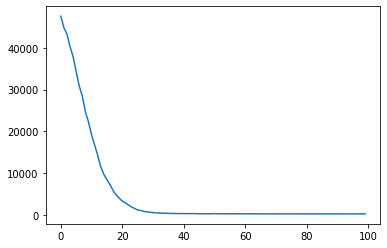

In [5]:
# Training

from torch.utils.data import DataLoader
from trainer.NP_trainer import MultiTaskNeuralProcessTrainer
from data_loader.data_loader import FGNetDataLoader

batch_size = 1
# num of training set = 17
num_context = 17
# num of test set = 1
num_target = 1


data_loader = FGNetDataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# All params = param of shared part + task_num * param of task-specific part
model_params = []
model_params += neuralprocess['encoder'].parameters()
for i in range(num_of_people):
    model_params += neuralprocess[i].parameters() 

optimizer = torch.optim.Adam(model_params, lr=3e-4)
mtnp_trainer = MultiTaskNeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  data_loader = data_loader, task_num = num_of_people)

neuralprocess['encoder'].training = True
# neuralprocess_decoder don't need to distinguish the state of training

mtnp_trainer.train(100)
#save first model parameters trained on the whole dataset
# torch.save(neuralprocess.state_dict(), r'D:\PycharmProjects\ANP\neural-processes\trained_models\age_estimation\firstWholeTrained.ckpt')
plt.plot(range(len(mtnp_trainer.epoch_loss_history)),mtnp_trainer.epoch_loss_history)
plt.show()